Name : Pramod Mahajan Chikkaballekere Manjunatha

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import shutil
import sys
import json

In [2]:
def get_mnist():
    # The code to download the mnist data original came from
    # https://cntk.ai/pythondocs/CNTK_103A_MNIST_DataLoader.html
    
    import gzip
    import numpy as np
    import os
    import struct

    try: 
        from urllib.request import urlretrieve 
    except ImportError: 
        from urllib import urlretrieve

    def load_data(src, num_samples):
        print("Downloading " + src)
        gzfname, h = urlretrieve(src, "./delete.me")
        print("Done.")
        try:
            with gzip.open(gzfname) as gz:
                n = struct.unpack("I", gz.read(4))
                # Read magic number.
                if n[0] != 0x3080000:
                    raise Exception("Invalid file: unexpected magic number.")
                # Read number of entries.
                n = struct.unpack(">I", gz.read(4))[0]
                if n != num_samples:
                    raise Exception(
                        "Invalid file: expected {0} entries.".format(num_samples)
                    )
                crow = struct.unpack(">I", gz.read(4))[0]
                ccol = struct.unpack(">I", gz.read(4))[0]
                if crow != 28 or ccol != 28:
                    raise Exception(
                        "Invalid file: expected 28 rows/cols per image."
                    )
                # Read data.
                res = np.frombuffer(
                    gz.read(num_samples * crow * ccol), dtype=np.uint8
                )
        finally:
            os.remove(gzfname)
        return res.reshape((num_samples, crow, ccol)) / 256


    def load_labels(src, num_samples):
        print("Downloading " + src)
        gzfname, h = urlretrieve(src, "./delete.me")
        print("Done.")
        try:
            with gzip.open(gzfname) as gz:
                n = struct.unpack("I", gz.read(4))
                # Read magic number.
                if n[0] != 0x1080000:
                    raise Exception("Invalid file: unexpected magic number.")
                # Read number of entries.
                n = struct.unpack(">I", gz.read(4))
                if n[0] != num_samples:
                    raise Exception(
                        "Invalid file: expected {0} rows.".format(num_samples)
                    )
                # Read labels.
                res = np.frombuffer(gz.read(num_samples), dtype=np.uint8)
        finally:
            os.remove(gzfname)
        return res.reshape((num_samples))


    def try_download(data_source, label_source, num_samples):
        data = load_data(data_source, num_samples)
        labels = load_labels(label_source, num_samples)
        return data, labels
    
    
    # Not sure why, but yann lecun's website does no longer support 
    # simple downloader. (e.g. urlretrieve and wget fail, while curl work)
    # Since not everyone has linux, use a mirror from uni server.
    #     server = 'http://yann.lecun.com/exdb/mnist'
    server = 'https://raw.githubusercontent.com/fgnt/mnist/master'
    
    # URLs for the train image and label data
    url_train_image = f'{server}/train-images-idx3-ubyte.gz'
    url_train_labels = f'{server}/train-labels-idx1-ubyte.gz'
    num_train_samples = 60000

    print("Downloading train data")
    train_features, train_labels = try_download(url_train_image, url_train_labels, num_train_samples)

    # URLs for the test image and label data
    url_test_image = f'{server}/t10k-images-idx3-ubyte.gz'
    url_test_labels = f'{server}/t10k-labels-idx1-ubyte.gz'
    num_test_samples = 10000

    print("Downloading test data")
    test_features, test_labels = try_download(url_test_image, url_test_labels, num_test_samples)
    
    return train_features, train_labels, test_features, test_labels

In [3]:
train_features, train_labels, test_features, test_labels = get_mnist()

Done.
Done.
Done.
Done.


In [4]:
training_images = train_features.reshape(-1, 28*28)
test_images = test_features.reshape(-1, 28*28)

In [5]:
class Variable:
    def __init__(self, value, operation):
        self.value = np.array(value)
        self.operation = operation
    
class Parameter(Variable):
    """
    This class should be used for Variables that are learnable.
    You can later use this class to distinguish learnable variables
    from other variables (`isinstance(variable, Parameter)`).
    """
    def __init__(self, value):
        super().__init__(value, operation=None)
        self.gradient = np.zeros_like(self.value)
        
class Input(Variable):
    """
    This class should be used as wrapper for inputs that are not learnable.
    """
    def __init__(self, value):
        super().__init__(value, operation=None)

In [6]:
class Layer:
    def __init__(self):
        self.parameters = []
    
    def apply(self, X):
        raise NotImplementedError
        
    def grad(self,D):
        raise NotImplementedError
        
    def add_param(self, values):
        param = Parameter(values)
        self.parameters.append(param)
        return param
    
    def update_parameters(self, optimizer):
        for param in self.parameters:
            optimizer.update(param)

In [7]:
class Sequential(Layer):
    def __init__(self, *layers):
        super().__init__()
        self.layers = layers
        for layer in layers:
            self.parameters.extend(layer.parameters) 
        
    def apply(self, X):
        backprops = []
        oper = X
        
        for layer in self.layers:
            oper, backprop = layer.apply(oper)
            backprops.append(backprop)

        def grad(D):
            for backprop in reversed(backprops):
                D = backprop(D)
            return D
        
        return oper , grad

In [8]:
class AffineLayer(Layer):
    def __init__(self, in_units, out_units):
        super().__init__()
        least = 0.01
        w_values = np.random.uniform(size=[in_units, out_units],
                    low=-least,
                    high=least
                    )
        self.W = self.add_param(w_values)
        self.b = self.add_param(np.zeros(shape=out_units))
        
    def apply(self, X):
        
        def grad(D):
            self.W.gradient = np.einsum('ji,jk->ik',X,D)
            self.b.gradient = np.sum(D,axis=0)
            bck_val = np.einsum('ij,kj->ik',D,self.W.value)
            return bck_val
        
        frd_val = np.einsum('ij,jk->ik',X,self.W.value) + self.b.value # adding bias
       
       
        return frd_val, grad

In [9]:
# define Relu activation layer
class ReLU(Layer):
    def apply(self, X):
        z = np.maximum(X, 0)  
        
        def grad(D):
            gx = D.copy()
            
            # Modify `gx` such that the gradient is corrected for x < 0.
            gx[X < 0] = 0 
            return gx

        return z , grad
    
# define sigmoid activation layer    
class Sigmoid(Layer):
    def apply(self, X):
        oper = 1/(1+np.exp(-X))
        
        def gradient(D):
            return D 
        
        return oper, gradient
    
# define optimizer as SGD
class SGD():
    def __init__(self, lr=0.001):
        self.lr = lr

    def update(self, param):
        param.value = param.value - self.lr * param.gradient 

In [10]:
# define cross entropy loss
def cross_entropy(predictions, targets, epsilon=1e-11):
    ce = -(np.sum(targets*np.log(predictions)))   # sum(p * logpi)
    error = predictions - targets  
    return ce , error  

In [11]:
# one hot to specify mulitclass classification    
def one_hot_encoder(train_labels):
    r = train_labels.shape[0]
    one_hot = np.zeros((r, 10))
    for i in range(r):
        one_hot[i][train_labels[i]] = 1
    return one_hot

In [12]:
class MNIST():
    def __init__(self, model, loss_function, optimizer):
        self.model = model
        self.loss = loss_function
        self.optimizer = optimizer
      
    # batch_size per update(specified later in training)
    def train_as_batch(self,X_train,Y_train):
        Y_train_, gradient = self.model.apply(X_train)
        Loss , D = self.loss(Y_train_, Y_train)          
        gradient(D)
        self.model.update_parameters(self.optimizer)
        return Loss
  
    def train(self, X_train, Y_train, batch_size , epochs):
        loss = []    # empty array to append loss values, which can be plotted later for better visualization
        for epoch in range(epochs):
            p = np.random.permutation(len(X_train))
            L_coll = 0
            for val in range(0, len(X_train), batch_size):
                X_batch = X_train[p[val:val + batch_size]]
                Y_batch = Y_train[p[val:val + batch_size]]
                L_coll += self.train_as_batch(X_batch, Y_batch)
            loss.append(L_coll)
        return loss
    
    # predicts accuracy of my model's prediction compared to actual output
    def accuracy(y_pred, y_test):
        correct_predictions = np.count_nonzero(y_pred==y_test)
        acc = correct_predictions / (y_test.shape[0]/100)
        print("The Model has achieved the accuracy of " + str(acc) + "% on test dataset.")
        return acc
    
    def predict(self, X_test):
        ypred, nothing = self.model.apply(X_test)
        return ypred.argmax(axis=-1)
    
    def dump_parameters(self,file):
        with open(file, 'w') as fp:
            json.dump([p.value.tolist() for p in self.model.parameters],fp)
            print('Wrote the parameters')
            
    def load_parameters(self, file):
        with open(file) as fp:
            parameters_values = json.load(fp)
        for p, p_value in zip(self.model.parameters, parameters_values):
            p.value[...] = p_value
        print('Loaded the parameters')

In [13]:
# create a model with 1 input layer, 1 hidden layer with 500 neurons, output layer of 10 neurons, one for each of 10 digits
neurons_in_layer = 500
lr = 0.008   # Learning rate
epochs = 35
batch_size = 32

X_train = training_images

y_train = train_labels
Y_train = one_hot_encoder(train_labels) 

X_test = test_images
Y_test = test_labels

model = MNIST(Sequential(AffineLayer(784, neurons_in_layer), ReLU(), AffineLayer(neurons_in_layer, Y_train.shape[1]),Sigmoid()), 
    loss_function = cross_entropy, optimizer = SGD(lr=lr))

losses = model.train(X_train, Y_train, batch_size=batch_size, epochs=epochs)


In [14]:
# save weights to a json file
model.dump_parameters("wt_final.json")

Wrote the parameters


In [15]:
#create a new empty model here to load weights
hidden_neurons = 500
lr = 0.008

val_model = MNIST(
    Sequential(
        AffineLayer(784, hidden_neurons), ReLU(), 
        AffineLayer(hidden_neurons, 10),Sigmoid()), 
    loss_function = cross_entropy, 
    optimizer = SGD(lr=lr)
)

In [16]:
# load weights from a saved json file in a new model
val_model.load_parameters("wt_final.json")

Loaded the parameters


In [17]:
# use the new empty model with weights loaded from json to make prediction
val_model_accuracy = MNIST.accuracy(val_model.predict(X_test), Y_test)

The Model has achieved the accuracy of 98.57% on test dataset.


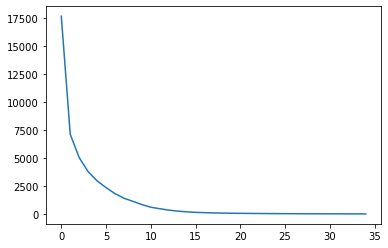

The Model has achieved the accuracy of 98.57% on test dataset.


In [18]:
# plot loss
plt.plot(losses)
plt.show()
# acuuracy prediction
y_pred = model.predict(X_test)
acc = MNIST.accuracy(y_pred, Y_test)